導入數據

In [3]:

import warnings
warnings.filterwarnings("ignore")  # 屏蔽 warning

%matplotlib inline

import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import normalize
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from scipy import sparse as sp
import numpy as np
import matplotlib.pyplot as plt
import os
import _pickle as pkl
import scipy as sp

# 下載必要的 NLTK 數據
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

df = pd.read_csv('./dataset/train.csv')
print(df.shape)  # 输出 (行数, 列数)
print(df.head(5))

(27643, 3)
   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


預處理數據

In [ ]:

import re
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction import text as sk_text
from scipy import sparse as sp
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import normalize

# ---- 1) 正文起点：出现就截断其后全部 ----
_BODY_OPEN = re.compile(
    r'(?is)<\s*(section|div|article)\b[^>]*\b'
    r'(?:article-content|article-body|content-body|post-content)\b[^>]*>'
)

# ---- 2) 小工具 ----
_MONTH = dict(jan='01', feb='02', mar='03', apr='04', may='05', jun='06',
              jul='07', aug='08', sep='09', oct='10', nov='11', dec='12')

def _norm(s: str) -> str:
    return re.sub(r'[\W]+', ' ', (s or '').lower()).strip()

def _slug(s: str) -> str:
    """把任意文本做成 token 安全的 slug（保留 a-z0-9_）"""
    return re.sub(r'[^a-z0-9_]+', '', _norm(s).replace(' ', '_'))

def _bucket(n, edges):
    """数值分桶：edges=[0,1,3,5] -> b0_1, b1_3, b3_5, b5p"""
    if n is None:
        return 'unk'
    for i in range(len(edges)-1):
        if edges[i] <= n < edges[i+1]:
            return f"b{edges[i]}_{edges[i+1]}"
    return f"b{edges[-1]}p"

def _aspect_bucket(w, h):
    if not w or not h:
        return 'unk'
    r = w / h
    if r < 0.9: return 'tall'
    if r < 1.2: return 'squareish'
    if r < 1.8: return 'landscape'
    return 'ultrawide'

def _img_size_bucket(w, h):
    if not w or not h:
        return 'unk'
    area = w*h
    if area <  80_000:  return 'xs'
    if area < 230_000:  return 'sm'     # ~640x360
    if area < 920_000:  return 'md'     # ~1280x720
    if area < 2_100_000: return 'lg'    # ~1920x1080
    return 'xl'

def _parse_wh_from_src(src: str):
    """从 URL 中粗略抓取 .../950x534/... 这样的尺寸"""
    if not src:
        return None, None
    m = re.search(r'/(\d{2,5})x(\d{2,5})/', src)
    if m:
        return int(m.group(1)), int(m.group(2))
    return None, None

# ---- 3) 强化版预处理：返回分組特徵字典 ----
def preprocessor(html: str) -> dict:
    if not isinstance(html, str):
        html = "" if html is None else str(html)

    # A) 剪掉正文：只保留正文前（页眉/标题区）
    m = _BODY_OPEN.search(html)
    header_html = html[:m.start()] if m else html

    # B) 解析 header_html
    soup = BeautifulSoup(header_html, 'html.parser')

    # 标题（优先 h1.title -> h1 -> <title>）
    title_raw = None
    h1 = soup.find('h1', class_=lambda c: (isinstance(c, list) and any('title' in x for x in c)) or (isinstance(c, str) and 'title' in c)) \
         or soup.find('h1')
    if h1:
        title_raw = h1.get_text(' ', strip=True)
    elif soup.title:
        title_raw = soup.title.get_text(' ', strip=True)
    title_tokens = _norm(title_raw)

    # 作者
    author = None
    by = soup.find(class_=lambda c: c and ('byline' in c or 'author_name' in c))
    if by:
        author = by.get_text(' ', strip=True)
    if not author:
        a = soup.find('a', href=re.compile(r'/author/[^/]+/?$', re.I))
        if a:
            author = a.get_text(' ', strip=True)
    author_slug = _slug(re.sub(r'^\s*by\s+', '', author or '', flags=re.I))

    # 频道/类型
    channel = None
    art = soup.find('article')
    if art and art.has_attr('data-channel'):
        channel = art['data-channel']
    if not channel and art:
        cls = ' '.join(art.get('class', []))
        mch = re.search(r'\b(news|tech|world|sports?|business|entertainment|culture|life|science)\b', cls, re.I)
        if mch: channel = mch.group(1)
    channel_slug = _slug(channel or 'unknown')

    # 发布者
    publisher = None
    pub = soup.find('a', href=re.compile(r'/publishers/[^/]+/?', re.I))
    if pub:
        publisher = pub.get_text(' ', strip=True) or re.sub(r'.*/publishers/([^/]+)/?.*', r'\1', pub['href'], flags=re.I)
    publisher_slug = _slug(publisher or 'unknown')

    # 时间（年/月/星期/时段/是否周末/季节）
    year = month = weekday = tod = season = None
    is_weekend = None
    tm = soup.find('time')
    dt = tm['datetime'] if (tm and tm.has_attr('datetime')) else (tm.get_text(' ', strip=True) if tm else None)
    if dt:
        y = re.search(r'(20\d{2}|19\d{2})', dt)
        if y: year = y.group(1)
        mo = re.search(r'-(\d{2})-', dt) or re.search(r'\b(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b', dt, re.I)
        if mo:
            mm = mo.group(1).lower() if mo.lastindex else mo.group(0).lower()
            month = _MONTH.get(mm, mm)
        wd = re.search(r'\b(mon|tue|wed|thu|fri|sat|sun)\b', dt, re.I)
        if wd:
            weekday = wd.group(1).lower()
            is_weekend = weekday in ('sat', 'sun')
        hh = re.search(r'\b(\d{2}):(\d{2})', dt)
        if hh:
            h = int(hh.group(1))
            tod = 'morning' if 5 <= h < 12 else 'afternoon' if 12 <= h < 17 else 'evening' if 17 <= h < 22 else 'night'
        if month:
            m_i = int(month)
            season = 'spring' if 3 <= m_i <= 5 else 'summer' if 6 <= m_i <= 8 else 'autumn' if 9 <= m_i <= 11 else 'winter'

    # 媒体要素：图片/视频/链接计数 + 画像（主图/分辨率）
    imgs = soup.find_all('img')
    img_count = len(imgs)
    has_image = img_count > 0
    leadimg = soup.find(attrs={'data-fragment': 'lead-image'}) is not None
    max_w = max_h = None
    for im in imgs:
        w, h = _parse_wh_from_src(im.get('src', ''))
        if w and h:
            if not max_w or (w * h) > (max_w * max_h if (max_w and max_h) else 0):
                max_w, max_h = w, h
    img_size_bucket = _img_size_bucket(max_w, max_h)
    img_aspect_bucket = _aspect_bucket(max_w, max_h)
    videos = soup.find_all('video')
    iframes = soup.find_all('iframe')
    has_video = bool(videos) or any(re.search(r'(youtube|vimeo|dailymotion)', (fr.get('src') or ''), re.I) for fr in iframes)
    link_count = len(soup.find_all('a'))
    link_bucket = _bucket(link_count, [0, 1, 3, 6, 10])
    img_bucket = _bucket(img_count, [0, 1, 3, 5])

    # 标题可传播性特征
    raw = title_raw or ''
    title_has_num = bool(re.search(r'\d', raw))
    title_has_year = bool(re.search(r'\b(19|20)\d{2}\b', raw))
    title_has_q = '?' in raw
    title_has_exclaim = '!' in raw
    title_has_colon = ':' in raw
    is_listicle = bool(re.match(r'^\s*\d+', raw))
    upper_ratio = (sum(ch.isupper() for ch in raw) / max(1, sum(ch.isalpha() for ch in raw)))
    upper_bucket = 'low' if upper_ratio < 0.15 else 'mid' if upper_ratio < 0.4 else 'high'
    title_word_len = len(_norm(raw).split())
    title_char_len = len(re.sub(r'\s+', '', raw))
    tw_bucket = _bucket(title_word_len, [0, 4, 8, 12, 20])
    tc_bucket = _bucket(title_char_len, [0, 30, 60, 90, 140])

    # 分組特徵
    author_features = [f'author_{author_slug or "unknown"}']
    channel_features = [f'channel_{channel_slug}']
    publisher_features = [f'publisher_{publisher_slug}']
    time_features = [
        f'year_{year or "unk"}',
        f'month_{month or "unk"}',
        f'weekday_{weekday or "unk"}',
        f'tod_{tod or "unk"}',
        f'season_{season or "unk"}',
        'weekend' if is_weekend else 'weekday' if is_weekend is not None else 'weekend_unk',
    ]
    media_features = [
        'has_image' if has_image else 'no_image',
        f'imgcnt_{img_bucket}',
        'has_leadimg' if leadimg else 'no_leadimg',
        f'imgsize_{img_size_bucket}',
        f'imgaspect_{img_aspect_bucket}',
        'has_video' if has_video else 'no_video',
        f'linkcnt_{link_bucket}',
    ]
    title_form_features = [
        'is_listicle' if is_listicle else 'not_listicle',
        'title_has_num' if title_has_num else 'title_no_num',
        'title_has_year' if title_has_year else 'title_no_year',
        'title_has_q' if title_has_q else 'title_no_q',
        'title_has_exclaim' if title_has_exclaim else 'title_no_exclaim',
        'title_has_colon' if title_has_colon else 'title_no_colon',
        f'title_len_word_{tw_bucket}',
        f'title_len_char_{tc_bucket}',
        f'title_upper_{upper_bucket}',
    ]

    # 返回分組特徵字典
    return {
        'title_tokens': title_tokens,
        'author_features': ' '.join(author_features),
        'channel_features': ' '.join(channel_features),
        'publisher_features': ' '.join(publisher_features),
        'time_features': ' '.join(time_features),
        'media_features': ' '.join(media_features),
        'title_form_features': ' '.join(title_form_features),
    }

# Tokenizer
porter = PorterStemmer()
try:
    import nltk
    from nltk.corpus import stopwords as nltk_sw
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    STOP = set(nltk_sw.words('english'))
except Exception:
    STOP = set(sk_text.ENGLISH_STOP_WORDS)

def tokenizer_stem_keepmeta(text):
    toks = re.split(r'\s+', (text or '').strip())
    out = []
    for w in toks:
        if not w:
            continue
        # 元特征（含_或数字）直接保留，不做词干，不做停用词过滤
        if '_' in w or any(ch.isdigit() for ch in w):
            out.append(w)
        else:
            # 纯英文词：去停用词 + 词干
            if w.lower() not in STOP and re.fullmatch(r'[a-zA-Z]+', w):
                out.append(porter.stem(w.lower()))
    return out

# 向量器
vectorizers = {
    'title_tokens': HashingVectorizer(n_features=2**20, alternate_sign=False, ngram_range=(1, 3), stop_words='english'),
    'author_features': HashingVectorizer(n_features=2**16, alternate_sign=False, ngram_range=(1, 1)),
    'channel_features': HashingVectorizer(n_features=2**16, alternate_sign=False, ngram_range=(1, 1)),
    'publisher_features': HashingVectorizer(n_features=2**16, alternate_sign=False, ngram_range=(1, 1)),
    'time_features': HashingVectorizer(n_features=2**16, alternate_sign=False, ngram_range=(1, 1)),
    'media_features': HashingVectorizer(n_features=2**16, alternate_sign=False, ngram_range=(1, 1)),
    'title_form_features': HashingVectorizer(n_features=2**16, alternate_sign=False, ngram_range=(1, 1)),
}

def featurize(html_series: pd.Series) -> sp.csr_matrix:
    """將每個特徵組分別向量化、拼接並歸一化"""
    processed = html_series.astype(str).apply(preprocessor)
    
    # 提取各特徵組
    feature_texts = {key: processed.apply(lambda x: x[key] if x[key] else '') for key in vectorizers}
    
    # 分別 tokenize
    tokenized = {key: [tokenizer_stem_keepmeta(text) for text in feature_texts[key]] for key in vectorizers}
    
    # 分別向量化
    vectors = {key: vectorizers[key].transform([' '.join(tokens) for tokens in tokenized[key]]) 
               for key in vectorizers}
    
    # 水平拼接向量
    combined_vec = sp.hstack(list(vectors.values()), format='csr')
    
    # 歸一化（L2 範數）
    combined_vec = normalize(combined_vec, norm='l2', axis=1)
    
    return combined_vec

# 處理前5行
processed = df['Page content'].head(5).map(preprocessor)

for i, result in enumerate(processed):
    print(f"=== 文本 {i} ===")
    for key, value in result.items():
        print(f"{key}: {value[:500]}")  # 只打印前500字方便看
    print()

=== 文本 0 ===
title_tokens: nasa s grand challenge stop asteroids from destroying earth
author_features: author_clara_moskowitz
channel_features: channel_world
publisher_features: publisher_space_com
time_features: year_2013 month_06 weekday_wed tod_afternoon season_summer weekday
media_features: has_image imgcnt_b1_3 has_leadimg imgsize_md imgaspect_landscape no_video linkcnt_b1_3
title_form_features: not_listicle title_no_num title_no_year title_no_q title_no_exclaim title_has_colon title_len_word_b8_12 title_len_char_b30_60 title_upper_mid

=== 文本 1 ===
title_tokens: google s new open source patent pledge we won t sue unless attacked first
author_features: author_christina_warren_2013_03_28_17_40_55_utc
channel_features: channel_tech
publisher_features: publisher_unknown
time_features: year_2013 month_03 weekday_thu tod_evening season_spring weekday
media_features: has_image imgcnt_b1_3 has_leadimg imgsize_md imgaspect_landscape no_video linkcnt_b1_3
title_form_features: not_listicle

核心外訓練

In [14]:

import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from scipy import sparse as sp
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import text as sk_text

# ========== 数据流 & 划分 ==========
def get_stream(path, size):
    """按批读取，流式产生 DataFrame；把Popularity从{-1,1}映射到{0,1}。"""
    for chunk in pd.read_csv(path, chunksize=size):
        if 'Popularity' in chunk.columns:
            chunk['Popularity'] = (chunk['Popularity'].astype(int) == 1).astype(int)
        yield chunk

def get_data_streams(path, train_size=20000, val_size=6000, batch_size=500):
    """创建独立的训练与验证流（你的原框架：先整体读，再切分）。"""
    df = pd.read_csv(path)
    df['Popularity'] = (df['Popularity'].astype(int) == 1).astype(int)

    train_df = df.iloc[:train_size].reset_index(drop=True)
    val_df   = df.iloc[train_size:train_size+val_size].reset_index(drop=True)

    def train_generator():
        for i in range(0, len(train_df), batch_size):
            batch = train_df.iloc[i:i+batch_size]
            if len(batch) > 0:
                yield batch

    def val_generator():
        for i in range(0, len(val_df), batch_size):
            batch = val_df.iloc[i:i+batch_size]
            if len(batch) > 0:
                yield batch

    return train_generator(), val_generator(), len(train_df), len(val_df)

BATCH_SIZE = 400
TRAIN_SIZE = 25500
VAL_SIZE = 1000

# 使用改进的数据流
TRAIN_PATH = './dataset/train.csv'
train_stream, val_stream, train_size, val_size = get_data_streams(
    TRAIN_PATH, train_size=TRAIN_SIZE, val_size=VAL_SIZE, batch_size=BATCH_SIZE
)

iters = int((TRAIN_SIZE + BATCH_SIZE - 1) / BATCH_SIZE)  # 向上取整

# ========== 模型 ==========
classes = np.array([0, 1])

clf = SGDClassifier(
    loss="squared_hinge",           # 或 "hinge"
    penalty="elasticnet",
    alpha=1e-6,
    l1_ratio=0.15,
    learning_rate="invscaling",  # "constant"/"adaptive"/"optimal"/"invscaling"
    eta0= 5000,                   # 步长
    average=True,
    max_iter=1, tol=None,
    random_state=42
)

# ========== 评估函数：每个iter对“整個驗證集”計算AUC ==========
def eval_val_auc_full(clf, val_batches, vectorizer=None, use_decision_function=True):
    """逐批transform、逐批取分数，最后一次性算AUC（省内存）。"""
    all_scores, all_targets = [], []
    for vb in val_batches:
        Xv = featurize(vb['Page content'])
        if use_decision_function and hasattr(clf, "decision_function"):
            sv = clf.decision_function(Xv)
            scores = sv if sv.ndim == 1 else sv[:, 1]
        else:
            scores = clf.predict_proba(Xv)[:, 1]
        all_scores.append(scores)
        all_targets.append(vb['Popularity'].values)
    y = np.concatenate(all_targets)
    s = np.concatenate(all_scores)
    if np.unique(y).size < 2:
        return np.nan
    return roc_auc_score(y, s)

# ========== 训练循环（你的框架，几乎不变） ==========
train_auc_hist, val_auc_hist = [], []

# 把验证生成器“固化”为列表，便于每步都能完整评估
val_batches = list(val_stream)

EVAL_EVERY = 1  # 每K步评估一次全量验证集AUC；设为1就是每步都评估

for i in range(iters):
    try:
        # ===== 训练 =====
        train_batch = next(train_stream)
        X_train = train_batch['Page content']
        y_train = train_batch['Popularity'].values

        X_train_vec = featurize(X_train)

        if i == 0:
            clf.partial_fit(X_train_vec, y_train, classes=classes)
        else:
            clf.partial_fit(X_train_vec, y_train)

        # 训练AUC（用 decision_function；AUC 对单调变换不敏感）
        if np.unique(y_train).size == 2:
            train_scores = clf.decision_function(X_train_vec)
            train_auc = roc_auc_score(y_train, train_scores)
        else:
            train_auc = np.nan
        train_auc_hist.append(train_auc)

        # ===== 验证：整個驗證集（流式按批累加）=====
        if (i + 1) % EVAL_EVERY == 0:
            full_val_auc = eval_val_auc_full(clf, val_batches, use_decision_function=True)
            val_auc_hist.append(full_val_auc)
            print(f"[{i+1}/{iters}] Train AUC: "
                  f"{'%.4f' % train_auc if np.isfinite(train_auc) else 'nan'}, "
                  f"Full Val AUC: {'%.4f' % full_val_auc if np.isfinite(full_val_auc) else 'nan'}")
        else:
            print(f"[{i+1}/{iters}] Train AUC: "
                  f"{'%.4f' % train_auc if np.isfinite(train_auc) else 'nan'}")

    except StopIteration:
        print("數據流已結束")
        break

# ========== 最终一次全量验证 ==========
final_val_auc = eval_val_auc_full(clf, val_batches, use_decision_function=True)
print(f"Final Full Val AUC: {final_val_auc:.4f}")

[1/64] Train AUC: 0.7740, Full Val AUC: 0.5024
[2/64] Train AUC: 0.6481, Full Val AUC: 0.5150
[3/64] Train AUC: 0.6003, Full Val AUC: 0.5140
[4/64] Train AUC: 0.5736, Full Val AUC: 0.5132
[5/64] Train AUC: 0.5541, Full Val AUC: 0.5188
[6/64] Train AUC: 0.5927, Full Val AUC: 0.5239
[7/64] Train AUC: 0.5594, Full Val AUC: 0.5246
[8/64] Train AUC: 0.5801, Full Val AUC: 0.5270
[9/64] Train AUC: 0.5415, Full Val AUC: 0.5290
[10/64] Train AUC: 0.4895, Full Val AUC: 0.5300
[11/64] Train AUC: 0.5970, Full Val AUC: 0.5316
[12/64] Train AUC: 0.5634, Full Val AUC: 0.5324
[13/64] Train AUC: 0.5805, Full Val AUC: 0.5314
[14/64] Train AUC: 0.5232, Full Val AUC: 0.5310
[15/64] Train AUC: 0.5634, Full Val AUC: 0.5306
[16/64] Train AUC: 0.5790, Full Val AUC: 0.5316
[17/64] Train AUC: 0.5921, Full Val AUC: 0.5321
[18/64] Train AUC: 0.5570, Full Val AUC: 0.5323
[19/64] Train AUC: 0.5479, Full Val AUC: 0.5324
[20/64] Train AUC: 0.5561, Full Val AUC: 0.5348
[21/64] Train AUC: 0.5746, Full Val AUC: 0.5348
[

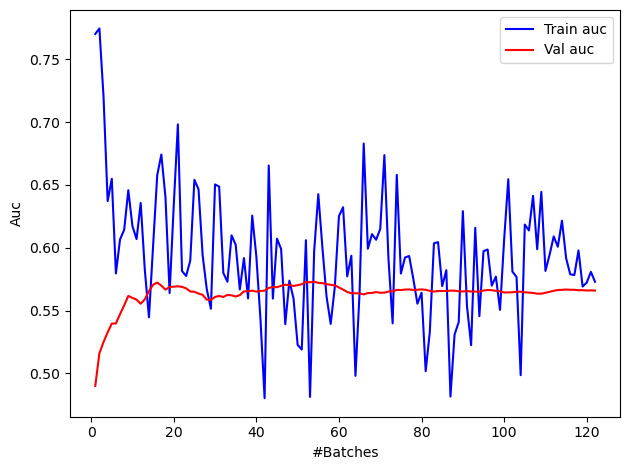

In [9]:

import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc_hist)+1), train_auc_hist, color='blue', label='Train auc')
plt.plot(
    np.linspace(1, len(train_auc_hist), len(val_auc_hist)), 
    val_auc_hist, 
    color='red', 
    label='Val auc'
)
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.savefig('./output/fig-out-of-core.png', dpi=300)
plt.show()



In [ ]:
# import optimized pickle written in C for serializing and
# de-serializing a Python object
import _pickle as pkl

# dump to disk
pkl.dump(vectorizers, open('output/vectorizers.pkl', 'wb'))
pkl.dump(clf, open('output/clf-sgd.pkl', 'wb'))

# load from disk
vectorizers = pkl.load(open('output/vectorizers.pkl', 'rb'))
clf = pkl.load(open('output/clf-sgd.pkl', 'rb'))

df_test = pd.read_csv('./dataset/test.csv')
import scipy as sp
test_vec = featurize(df_test['Page content'])
test_pred = sp.special.expit(clf.decision_function(test_vec))

submission = pd.DataFrame({
    'Id': df_test['Id'],
    'Popularity': test_pred
})
submission.to_csv('output/submission_53.csv', index=False)
print('Test predictions saved to output/submission_53.csv')